<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/siamese_net_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/calibretaliation/DeepLearning20211.git

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32529, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 32529 (delta 37), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32529/32529), 1.68 GiB | 25.13 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Checking out files: 100% (32428/32428), done.


## Import

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-bv6pnipg
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-bv6pnipg


In [ ]:
#@title Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import random

import os
import pickle

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model, callbacks
from tensorflow.keras.applications import resnet, mobilenet_v3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD


from pathlib import Path

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
#@title Load CSV

train_df = pd.read_csv('DeepLearning20211/data/train.csv')
test_df = pd.read_csv('DeepLearning20211/data/test.csv')

train_img_dir = Path('DeepLearning20211/data/train_images')
test_img_dir = Path('DeepLearning20211/data/test_images/')

In [ ]:
#@title Drop images with duplicated p-hash value

train_df = train_df.drop_duplicates(subset=['image_phash']).reset_index(drop=True)

In [ ]:
#@title Plot class cardinality distribution

# calculate number of images in each class
label_count = train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution')
plt.show()

In [ ]:
#@title Create validation set
val_df = train_df.sample(frac=1, random_state=14).groupby('label_group').nth(0)
val_df['label_group'] = val_df.index
val_df = val_df.reset_index(drop=True)

## Prepare dataset

In [ ]:
#@title Take one instance in each class as anchor

set_seed(42)
anchor_df = train_df.groupby('label_group').nth(0)

In [ ]:
num_triplets = 200

In [ ]:
def create_dataset(mode):
    assert mode == 'training' or mode == 'validation', "argument mode should be 'training' or 'validation'" 
    df = train_df if mode == 'training' else val_df

    # container to store image path
    anchor_container = []
    positive_container = []
    negative_container = []

    # for each anchor image, create num_triplets triplets
    for anchor_label in anchor_df.index:
        anchor = anchor_df['image'][anchor_label]

        positive_df = df[df['label_group'] == anchor_label]
        if len(positive_df) > 1:
            positive_df = positive_df[positive_df['image'] != anchor]

        negative_df = df.groupby('label_group').nth(0)
        negative_df['label_group'] = negative_df.index
        negative_df = negative_df.reset_index(drop=True)
        negative_df = negative_df[negative_df['label_group'] != anchor_label]
        for _ in range(num_triplets if mode == 'training' else 3):
            anchor_container.append(str(train_img_dir) + os.sep + anchor)
            positive_container.append(str(train_img_dir) + os.sep + np.squeeze(positive_df.sample(1)['image']))
            negative_container.append(str(train_img_dir) + os.sep + np.squeeze(negative_df.sample(1)['image']))

    return anchor_container, positive_container, negative_container

In [ ]:
# train_ds_raw = create_dataset(mode='training')
# val_ds_raw = create_dataset(mode='validation')

In [ ]:
# with open('DeepLearning20211/train_ds_raw.pkl', 'wb') as f:
#     pickle.dump(train_ds_raw, f)

# with open('DeepLearning20211/val_ds_raw.pkl', 'wb') as f:
#     pickle.dump(val_ds_raw, f)

In [ ]:
# with open('DeepLearning20211/train_ds_raw.pkl', 'rb') as f:
#     train_ds_raw = pickle.load(f)

# with open('DeepLearning20211/val_ds_raw.pkl', 'rb') as f:
#     val_ds_raw = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/train_ds_raw.pkl', 'rb') as f:
    train_ds_raw = pickle.load(f)

with open('/content/drive/MyDrive/val_ds_raw.pkl', 'rb') as f:
    val_ds_raw = pickle.load(f)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds_raw)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds_raw)

In [ ]:
resize_and_scale = tf.keras.Sequential(
    [
     tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True),
     tf.keras.layers.Rescaling(1./255)
     ]
)

data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomFlip("vertical"),
     tf.keras.layers.RandomRotation(0.2),
     tf.keras.layers.RandomContrast(0.5),
     tf.keras.layers.RandomZoom((-0.2, 0.2)),
     tf.keras.layers.RandomTranslation(0.14, 0.14),
     ]
)

def filepath_to_img(filepath):
    
    img_string = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_string)

    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))

    # if augment:
    #     img = data_augmentation(img)

    # img = resize_and_scale(img)

    return img

def configure_dataset(ds, mode):
    assert mode == 'training' or mode == 'validation', "mode should be 'training' or 'validation'" 
    
    if mode == 'training':
        ds = ds.shuffle(buffer_size=20000)
    
    ds = ds.map(lambda a_path, p_path, n_path: (filepath_to_img(a_path), 
                                                filepath_to_img(p_path), 
                                                filepath_to_img(n_path)), 
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=500)

    # ds.map(lambda a, p, n: (resize_and_scale(a), resize_and_scale(p), resize_and_scale(n)), num_parallel_calls=tf.data.AUTOTUNE)

    # if mode == 'validation':        ###############################
    ds = ds.cache()

    if mode == 'training':
        ds = ds.map(lambda a, p, n: (a, 
                                     data_augmentation(p), 
                                     n), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    if mode == 'training':
        ds = ds.batch(32)
    
    return ds

train_ds = configure_dataset(train_ds, mode='training')
val_ds = configure_dataset(val_ds, mode='validation')


In [ ]:
#@title Visualize some triplets

ncols = 3
nrows = 3
plt.figure(figsize=(4*ncols, 4*nrows))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows)
for anchor_batch, positive_batch, negative_batch in train_ds.take(1):
    i = 0
    for anchor, positive, negative in zip(anchor_batch, positive_batch, negative_batch):
        plt.subplot(spec[ncols*i])
        plt.imshow(anchor)
        plt.axis('off')
        plt.subplot(spec[ncols*i + 1])
        plt.imshow(positive)
        plt.axis('off')
        plt.subplot(spec[ncols*i + 2])
        plt.imshow(negative)
        plt.axis('off')
        
        i += 1
        if i == nrows:
            break
plt.show()

In [ ]:
# import shutil
# shutil.rmtree(str(temp_dir), ignore_errors=True)

## Setup model

In [23]:
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

output = layers.Flatten()(base_model.output)
output = layers.Dense(512, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(output)
output = layers.BatchNormalization()(output)

embedding = Model(base_model.input, output, name='Embedding')

trainable = False
for layer in base_model.layers:
    if layer.name == 'multiply_15':
        trainable = True
    layer.trainable = trainable

class Distance(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

anchor_input = layers.Input(name='anchor', shape=(224, 224, 3))
positive_input = layers.Input(name='positive', shape=(224, 224, 3))
negative_input = layers.Input(name='negative', shape=(224, 224, 3))

distances = Distance()(
    embedding(mobilenet_v3.preprocess_input(anchor_input)),
    embedding(mobilenet_v3.preprocess_input(positive_input)),
    embedding(mobilenet_v3.preprocess_input(negative_input))
)

siamese_base = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances
)

class SiameseNet(Model):
    """
    Siamese network with triplet loss:
        L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """
    def __init__(self, siamese_base, margin=0.5):
        super(SiameseNet, self).__init__()
        self.siamese_base = siamese_base
        self.margin = margin
        self.loss_tracker = metrics.Mean(name='loss')

    def call(self, inputs):
        return self.siamese_base(inputs)

    @tf.function
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_base(data)
        loss = tf.maximum(ap_distance + self.margin - an_distance, 0.0)
        return loss

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_base.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_base.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

    @tf.function
    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

    @property
    def metrics(self):
        # list our metrics here so the `reset_states()` can be called automatically.
        return [self.loss_tracker]



In [ ]:
model = SiameseNet(siamese_base)
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9, nesterov=True))
model.fit(train_ds, epochs=2, validation_data=val_ds, shuffle=True)

Epoch 1/2
   45/68775 [..............................] - ETA: 26:58:21 - loss: 0.4866

In [ ]:
models = {}
epoch_record = {}
histories = {}

In [ ]:
def remove_model(name):
    try:
        del models[name]
        del histories[name]
        del epoch_record[name]
    except:
        pass

def train_model(model, optimizer, max_epochs, reduce_lr_patience, early_stop_patience, checkpoint_name):

    callbacks = [
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=reduce_lr_patience, verbose=1),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience, verbose=1),
                #  tf.keras.callbacks.TensorBoard(logdir/model.name)
                ]
    if checkpoint_name is not None:
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/checkpoint/{}.hdf5'.format(checkpoint_name), monitor='val_loss', verbose=1, save_best_only=True))
    
    # shutil.rmtree(logdir/name, ignore_errors=True)     

    new_model = True
    if model.name in histories.keys() and input("'{}' already exists. Override? [y/n] ".format(model.name)) != 'y':
        new_model = False
    
    set_seed()

    if new_model:
        model.compile(
            optimizer=optimizer,
        )
        histories[model.name] = model.fit(
            train_ds,
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,
            validation_data=val_ds,
            callbacks=callbacks,
            shuffle=True
        )
        epoch_record[model.name] = [histories[model.name].epoch[-1]]

    else:
        model.optimizer.learning_rate.assign(optimizer.get_config()['learning_rate'])
        cont_history = model.fit(
            train_ds, 
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,     
            validation_data=val_ds,    
            callbacks=callbacks,
            initial_epoch=histories[model.name].epoch[-1] + 1,
            shuffle=True
        )
        epoch_record[model.name].append(cont_history.epoch[-1])
        histories[model.name].epoch += cont_history.epoch
        histories[model.name].history['loss'] += cont_history.history['loss']
        histories[model.name].history['val_loss'] += cont_history.history['val_loss']

    return model.name


plotter = tfdocs.plots.HistoryPlotter( 
    # metric = 'nonregu_mae',
    # smoothing_std=10
)

## Depricated

In [ ]:
#@title Depricated

min_cardinality = 4
max_cardinality = label_count.max()         # 39 in this dataset
augmented_list = []

progress = 0
for i in range(len(train_df)):
    # ten file: train_df.iloc[i]['image']
    # label_count[train_df.iloc[i]['label_group']]
    label_group = train_df.iloc[i]['label_group']
    class_cardinality = label_count[label_group]
    if class_cardinality < min_cardinality:
        progress += 1
        print(progress)
        img = image.load_img(train_img_dir/train_df.iloc[i]['image'])
        img = image.img_to_array(img)
        num_augmentation = math.ceil((min_cardinality - class_cardinality) / class_cardinality)
        for _ in range(num_augmentation):
            name = train_df.iloc[i]['image'][:-4] + '_AUGMENTED_' + str(_) + '.jpg'
            augmented_img = data_augmentation(img)
            image.save_img(train_img_dir/name, augmented_img)
            augmented_list.append({'image': name, 'label_group': label_group})


In [ ]:
augmented_train_df = train_df.append(augmented_list, ignore_index=True)

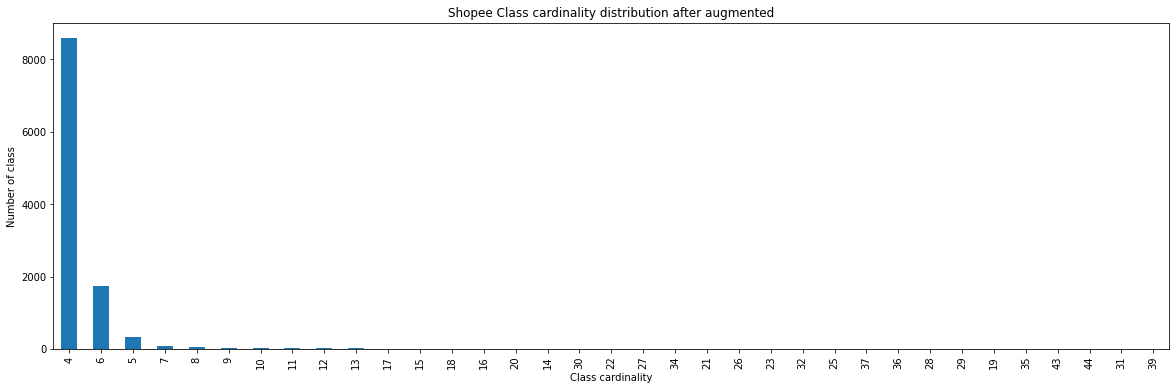

In [ ]:
#@title Plot class cardinality distribution after augmentation

# calculate number of images in each class
augmented_label_count = augmented_train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
augmented_label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution after augmented')
plt.show()